## Testing

In [25]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import iapws95_light
iapws95_light.print_verification_values()

Test case 1: rho = 838.025 kg m^{-3}, T = 500 K
Computed: 
phi0    |  2.047977336 | phir    | -3.426932057
phi0_d  |  0.384236747 | phir_d  | -0.364366650
phi0_dd | -0.147637878 | phir_dd |  0.856063701
phi0_t  |  9.046111061 | phir_t  | -5.814034352
phi0_tt | -1.932491850 | phir_tt | -2.234407369
phi0_dt |  0.000000000 | phir_dt | -1.121769147
Reference (9 significant figures): 
phi0    |  2.047977340 | phir    | -3.426932060
phi0_d  |  0.384236747 | phir_d  | -0.364366650
phi0_dd | -0.147637878 | phir_dd |  0.856063701
phi0_t  |  9.046111060 | phir_t  | -5.814034350
phi0_tt | -1.932491850 | phir_tt | -2.234407370
phi0_dt |  0.000000000 | phir_dt | -1.121769150

Test case 2: rho = 358 kg m^{-3}, T = 647 K
Computed: 
phi0    | -1.563196050 | phir    | -1.212026565
phi0_d  |  0.899441341 | phir_d  | -0.714012024
phi0_dd | -0.808994726 | phir_dd |  0.475730696
phi0_t  |  9.803439179 | phir_t  | -3.217225008
phi0_tt | -3.433163341 | phir_tt | -9.960295066
phi0_dt |  0.000000000 | phir_dt 

In [4]:
iapws95_light.print_timing()

Timing p(rho, T) calculations for scalar input.
iapws95_light: 354.5814027777775 us
Ideal gas    : 0.682899999996304 us
Relative load: 519.229x
=== Additional details ===
Number of coefficients in model: 247
Relative load per model dof:     2.102x


996.9600226949963

In [16]:
import iapws

p_ref = 1e6
T_ref = 300
print(f"iapws.py: Reference density of {iapws.IAPWS95(P=p_ref/1e6, T=T_ref).rho}")
# Set reference density in platofmr-independent way
rho_ref = 996.9600226950664

''' Cross-verification '''
# Finite difference check for phi implementation
d = 996.9600226950664 / iapws95_light.rhoc
t = iapws95_light.Tc / T_ref
_finite_diff_soln = 0.5*(iapws95_light.phir(d + 1e-5, iapws95_light.Tc/300) \
  - iapws95_light.phir(d - 1e-5, iapws95_light.Tc/300))/1e-5
print(f"phir_d eval: {iapws95_light.phir_d(d, iapws95_light.Tc/300) [0]}")
print(f"Finite diff: {_finite_diff_soln[0]}")

# Forward check of pressure routine
print(f"Reference pressure: {p_ref}")
print(f"Computed pressure:  {iapws95_light.p(rho_ref, T_ref)}")

crossverif_obj = iapws.IAPWS95(rho=rho_ref, T=T_ref)
phir = iapws95_light.phir(d, t)[0]
phi0 = iapws95_light.phi0(d, t)[0]
crossverf_phir = crossverif_obj._phir(crossverif_obj.Tc/T_ref,
  rho_ref/crossverif_obj.rhoc)["fir"]
crossverf_phi0 = crossverif_obj._phi0(crossverif_obj.Tc/T_ref,
  rho_ref/crossverif_obj.rhoc)["fio"]

print(f"Computed phir:  {phir}")
print(f"Reference phir: {crossverf_phir}")
print(f"Computed phi0:  {phi0}")
print(f"Reference phi0: {crossverf_phi0}")

iapws.py: Reference density of 996.9600226950664
phir_d eval: -0.32064199447122377
Finite diff: -0.3206419957990647
Reference pressure: 1000000.0
Computed pressure:  1000000.0001630188
Computed phir:  -9.573781605341168
Reference phir: -9.573781605342393
Computed phi0:  9.535031422701463
Reference phi0: 9.535031422672684


In [114]:
# Unphysical test: attempt to compute pressure using Helmholtz within mixed
#   phase
print(f"Attempted p:  {iapws95_light.p(859.6317217178832, T_ref)}")
print(f"Reference p:  {iapws.IAPWS95(rho=859.6317217178832, T=T_ref).P*1e6}")
print(f"Saturation p: {iapws95_light.prho_sat(T_ref)[0][0]}")

Attempted p:  999999.9999971485
Reference p:  3536.806752269702
Saturation p: 3536.8067733299504


Density at 0.9 MPa, 300 K: 996.9152071076022


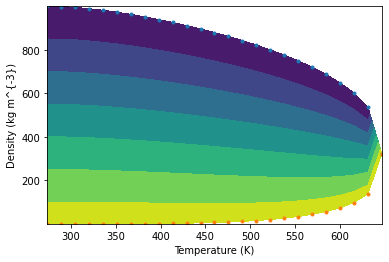

In [115]:
# Iterative thermodynamic functions test
print(f"Density at 0.9 MPa, 300 K: {iapws95_light.rho_pt(0.9e6, 300)[0]}")

# Compute saturation curves
range_T = np.linspace(273.15, iapws95_light.Tc, 25)
rhol, rhov = iapws95_light.get_saturation_density_curves(range_T)
# Define sampling range for mixed phase
coord_range = np.linspace(0,1,7)
mg_T, mg_rho = np.meshgrid(range_T, coord_range)
mg_x = np.zeros_like(mg_T)
# Compute vapour mass fraction using iapws95_light.x
for i, j in np.ndindex(mg_T.shape):
  mg_rho[i,j] = rhov[j] + coord_range[i] * (rhol[j] - rhov[j])
  mg_x[i,j] = iapws95_light.x(mg_rho[i,j], mg_T[i,j])

plt.figure(1)
# Show mass fraction inside mixed phase region
plt.contourf(mg_T, mg_rho, mg_x)
# Plot saturation curves
plt.plot(range_T, rhol, '.')
plt.plot(range_T, rhov, '.')
plt.xlabel("Temperature (K)")
plt.ylabel("Density (kg m^{-3})")
plt.show()

In [49]:
import iapws95_light
range_rho = np.linspace(1.0, 1300, 400)
range_T = np.linspace(273.15, 800, 801)
mg_rho, mg_T = np.meshgrid(range_rho, range_T)
mg_p = np.zeros_like(mg_rho)

# Compute pressures
mg_p.ravel()[:] = iapws95_light.p(mg_rho.ravel(), mg_T.ravel())
mg_pclip = np.clip(mg_p, None, 10e9)

Text(0, 0.5, 'Density (kg/m^3)')

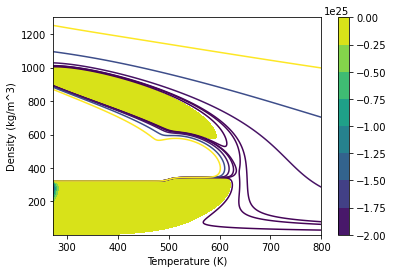

In [64]:
plt.contourf(mg_T, mg_rho, mg_pclip)
# plt.clim(1e2 ,1e9)
cb = plt.colorbar()
plt.contour(mg_T, mg_rho, mg_p, levels=[10e6, 20e6, 24e6, 60e6, 240e6, 1e9])

plt.xlabel("Temperature (K)")
plt.ylabel("Density (kg/m^3)")
# plt.ylim(0,10e6)

## Feature Development: Saturation Curve

In [ ]:
# Saul and Wagner 1987

# Context: (rho, T) -> p_sat by Maxwell construction
t = iapws95_light.Tc / T_ref
rho = rho_ref

# Saturated liquid density correlation (2.3)
_powsb = np.array([1/3, 2/3, 5/3, 16/3, 43/3, 110/3])
_coeffsb = [1.99206, 1.10123, -5.12506e-1, -1.75263, -45.4485, -6.75615e5]
d1 = 1.0 + np.dot((1.0-1.0/t)**_powsb, _coeffsb)
# Saturated vapour density correlation (2.2)
_powsc = np.array([1/3, 2/3, 4/3, 9/3, 37/6, 71/6])
_coeffsc = [-2.02957, -2.68781, -5.38107, -17.3151, -44.6384, -64.3486]
d2 = np.exp(np.dot((1.0-1.0/t)**_powsc, _coeffsc))

# Define size-2 system for d-bounds on phase transition (Maxwell construction)
phir_d = lambda d: iapws95_light.phir_d(d, t)
phir = lambda d: iapws95_light.phir(d, t)
phi0 = lambda d: iapws95_light.phi0(d, t)
eq1 = lambda d1, d2: d2 * phir_d(d2) - d1 * phir_d(d1) - phir(d1) - phi0(d1) +phir(d2) + phi0(d2)
eq2 = lambda d1, d2: d1 + d1**2 * phir_d(d1) - d2 - d2**2 * phir_d(d2)
eqvec = lambda d: np.array([eq1(d[0], d[1]), eq2(d[0], d[1])]).squeeze()

# Solve system using fsolve, initial guess using older sat curve correlations
import scipy.optimize
d_init = np.array([d1, d2])
d_final = scipy.optimize.fsolve(eqvec, d_init)
print("Init, final, residuals:")
print(d_init, d_final, eqvec(d_final))

# Get saturation densities at given T
rho_l, rho_v = d_final * iapws95_light.rhoc

# Use either for saturation pressure
psat = d_final[0]*(1.0 + d_final[0]*iapws95_light.phir_d(d_final[0], t)) \
  * iapws95_light.rhoc * iapws95_light.R * T_ref
# p = d_final[1]*(1.0 + d_final[1]*iapws95_light.phir_d(d_final[1], t)) \
  # * iapws95_light.rhoc * iapws95_light.R * T_ref
p = psat
print(f"psat = {psat}")

# context: 
if rho <= rho_l and rho >= rho_v:
  # Return saturation pressure
  print(f"Mixture")
elif rho < rho_v:
  rho = rho_v/iapws95_light.rhoc
else:
  rho = rho_l/iapws95_light.rhoc

In [ ]:
# Saturation pressure recovery check
d_final[0]*(1.0 + d_final[0]*iapws95_light.phir_d(d_final[0], t)) * iapws95_light.rhoc * iapws95_light.R * T_ref, \
  d_final[1]*(1.0 + d_final[1]*iapws95_light.phir_d(d_final[1], t)) * iapws95_light.rhoc * iapws95_light.R * T_ref

In [ ]:
# Get rho bounds given T
rho_bounds = d_final * iapws95_light.rhoc
rho_l = rho_bounds[0]
rho_v = rho_bounds[1]
# Context: (p, T) -> rho
rho = rho_ref

# Use either for saturation pressure
psat = d_final[0]*(1.0 + d_final[0]*iapws95_light.phir_d(d_final[0], t)) \
  * iapws95_light.rhoc * iapws95_light.R * T_ref
# p = d_final[1]*(1.0 + d_final[1]*iapws95_light.phir_d(d_final[1], t)) \
  # * iapws95_light.rhoc * iapws95_light.R * T_ref
p = psat
print(f"psat = {psat}")

if rho <= rho_l and rho >= rho_v:
  # Return saturation pressure
  print(f"Mixture")
elif rho < rho_v:
  rho = rho_v/iapws95_light.rhoc
else:
  rho = rho_l/iapws95_light.rhoc

print(d)
for i in range(5):
  val = - p / (iapws95_light.rhoc * iapws95_light.R * T_ref) + d + d **2 * iapws95_light.phir_d(d, t)
  deriv = 1 + 2 * d * iapws95_light.phir_d(d, t) + d**2 * iapws95_light.phir_dd(d, t)
  d -= val / deriv
  print(d)
print(d * iapws95_light.rhoc)

## Structure development

In [2]:
import csv
import numpy as np

''' Data loading ''' 

DATAPATH_IDEAL = 'ideal.csv'
DATAPATH_RES0 = 'residual_1_51.csv'
DATAPATH_RES1 = 'residual_52_54.csv'
DATAPATH_RES2 = 'residual_55_56.csv'

with open(DATAPATH_IDEAL, newline='') as csvfile:
  reader = csv.DictReader(csvfile, delimiter='\t')
  ideal_arraydict = [row for row in reader]

with open(DATAPATH_RES0, newline='') as csvfile:
  reader = csv.DictReader(csvfile, delimiter='\t')
  residual0_arraydict = [row for row in reader]

with open(DATAPATH_RES1, newline='') as csvfile:
  reader = csv.DictReader(csvfile, delimiter='\t')
  residual1_arraydict = [row for row in reader]

with open(DATAPATH_RES2, newline='') as csvfile:
  reader = csv.DictReader(csvfile, delimiter='\t')
  residual2_arraydict = [row for row in reader]

''' Data prep '''
n_ideal = np.array([float(obj["n_i"]) for obj in ideal_arraydict])
g_ideal = np.array([float(obj["g_i"]) for obj in ideal_arraydict])

# Compile shared residual coefficients
n_res = np.hstack(([float(obj["n_i"]) for obj in residual0_arraydict],
  [float(obj["n_i"]) for obj in residual1_arraydict],
  [float(obj["n_i"]) for obj in residual2_arraydict]))
d_res = np.hstack(([float(obj["d_i"]) for obj in residual0_arraydict],
  [float(obj["d_i"]) for obj in residual1_arraydict],
  [1.0 for obj in residual2_arraydict]))
t_res = np.hstack(([float(obj["t_i"]) for obj in residual0_arraydict],
  [float(obj["t_i"]) for obj in residual1_arraydict],
  [0.0 for obj in residual2_arraydict]))

c_res1_51 = np.array([float(obj["c_i"]) for obj in residual0_arraydict])

c_res52_54 = np.array([float(obj["c_i"]) for obj in residual1_arraydict])
alpha_res52_54 = np.array([float(obj["alpha_i"]) for obj in residual1_arraydict])
beta_res52_54 = np.array([float(obj["beta_i"]) for obj in residual1_arraydict])
gamma_res52_54 = np.array([float(obj["gamma_i"]) for obj in residual1_arraydict])
eps_res52_54 = np.array([float(obj["eps_i"]) for obj in residual1_arraydict])

a_res55_56 = np.array([float(obj["a_i"]) for obj in residual2_arraydict])
b_res55_56 = np.array([float(obj["b_i"]) for obj in residual2_arraydict])
B_res55_56 = np.array([float(obj["B_i"]) for obj in residual2_arraydict])
C_res55_56 = np.array([float(obj["C_i"]) for obj in residual2_arraydict])
D_res55_56 = np.array([float(obj["D_i"]) for obj in residual2_arraydict])
A_res55_56 = np.array([float(obj["A_i"]) for obj in residual2_arraydict])
beta_res55_56 = np.array([float(obj["beta_i"]) for obj in residual2_arraydict])

''' Set up static parameters '''
Tc = 647.096  # K
rhoc = 322    # kg / m^3
R = 0.46151805 # kJ / kg K
# Generic precomputation
_exp1_55_56 = 0.5 / (beta_res55_56)

In [3]:
''' Simulate input '''
rho = 838.025
T = 500

rho = 358
T = 647

In [4]:
''' Compute reduced variables '''

# Reciprocal reduced volume
d = rho / rhoc
# Reciprocal reduced temperature
t = Tc / T

In [5]:
def phi(d, t):
  ''' Reduced Helmholtz function f/(RT). ''' 

  # Scalar precomputation
  d_quad = (d-1.0)**2

  ''' Ideal-gas part of Helmholtz function f '''
  phi0 = np.log(d) + n_ideal[0] + n_ideal[1] * t + n_ideal[2] * np.log(t)
  phi0 += np.dot(n_ideal[3:8], np.log(1.0 - np.exp(-g_ideal[3:8] * t)))

  ''' Residual part of Helmholtz function f
  Evaluated using two registers that combine as
    np.dot( coeffs, np.exp(exponents) ).
  '''
  # Allocate exponent cache
  exponents = np.zeros_like(n_res)
  # Allocate and evaluate coeffs
  coeffs = n_res * (d ** d_res) * (t ** t_res)

  # Compute distance term for 1-indices 55 to 56
  theta = (1 - t) + A_res55_56 * d_quad ** _exp1_55_56
  Delta = theta**2 + B_res55_56 * d_quad ** a_res55_56
  # Factor in Delta**b_i term for 1-indices from 55 to 56
  coeffs[54:56] *= Delta ** b_res55_56

  # Compute exponents for 1-indices 8 to 51 as -d**c_i
  exponents[7:51] = -d ** c_res1_51[7:51]
  # Compute exponents for 1-indices from 52 to 54
  exponents[51:54] = -alpha_res52_54 * (d - eps_res52_54) ** 2 \
    -beta_res52_54*(t - gamma_res52_54)**2
  # Compute exponents for 1-indices from 55 to 56
  exponents[54:56] = -C_res55_56 * d_quad \
    -D_res55_56*(t - 1)**2

  # Compute residual part of reduced Helmholtz
  phir = np.dot(coeffs, np.exp(exponents))

  return (phi0, phir)

def Z(d, t):
  ''' Compressibility factor evaluation
  The compressibility factor Z is given by
    Z == p * v / (R * T) = 1 + delta * d(phi_R)/d(delta),
  where d(phi_R)/d(delta) is the partial derivative of the residual
  part of the reduced Helmholtz function, with respect to d = rho/rhoc.
  Evaluated using two registers that combine as
    np.dot( coeffs, np.exp(exponents) ).
  '''

  # Scalar precomputation
  d_quad = (d-1)**2

  # Allocate exponent cache
  exponents = np.zeros_like(n_res)
  # Allocate and partially evaluate coeffs
  coeffs = n_res * (d ** (d_res-1)) * (t ** t_res)
  # Factor in d_i - c_i * d**c_i term
  coeffs[0:51] *= (d_res[0:51] - c_res1_51 * d ** c_res1_51)
  coeffs[51:54] *= d_res[51:54] - 2.0 * alpha_res52_54 * d * (d - eps_res52_54)

  # Compute distance term for 1-indices 55 to 56
  theta = (1 - t) + A_res55_56 * d_quad ** _exp1_55_56
  Delta = theta**2 + B_res55_56 * d_quad ** a_res55_56
  # Factor in other terms for 1-indices from 55 to 56 in two steps
  coeffs[54:56] *= (
    Delta * (1.0 - 2.0 * C_res55_56 * (d-1.0) * d)
    + b_res55_56 * d * (d-1.0) * (
      A_res55_56 * theta * 2 / beta_res55_56 * d_quad**(_exp1_55_56 - 1.0)
      + 2 * B_res55_56 * a_res55_56 * d_quad**(a_res55_56 - 1.0)
    )
  )
  coeffs[54:56] *= Delta ** np.where(Delta != 0, b_res55_56-1, 1.0)

  # Compute exponents for 1-indices 8 to 51 as -d**c_i
  exponents[7:51] = -d ** c_res1_51[7:51]
  # Compute exponents for 1-indices from 52 to 54
  exponents[51:54] = -alpha_res52_54 * (d - eps_res52_54) ** 2 \
    -beta_res52_54*(t - gamma_res52_54)**2
  # Compute exponents for 1-indices from 55 to 56
  exponents[54:56] = -C_res55_56 * d_quad \
    -D_res55_56*(t - 1)**2

  # Reduce
  phir_d = np.dot(coeffs, np.exp(exponents))
  return 1 + d * phir_d


In [6]:
''' Compute reduced variables '''
# Reciprocal reduced volume
d = rho / rhoc
# Reciprocal reduced temperature
t = Tc / T

# phi, phir_d, Z
print(f"phi0 = {phi(d, t)[0]:.8f}, phir = {phi(d, t)[1]:.8f}, phir_d = {(Z(d, t) - 1)/d:.9f}")

# Print verification values
verification_string = '''
For T = 647 K, rho = 358 kg m^{-3}:
phi0 = -1.56319605
phir = -1.21202657
phir_d = -0.714012024
'''
print(verification_string)


phi0 = -1.56319605, phir = -1.21202657, phir_d = -0.714012024

For T = 647 K, rho = 358 kg m^{-3}:
phi0 = -1.56319605
phir = -1.21202657
phir_d = -0.714012024



In [232]:
from time import perf_counter

print(f"Timing p(rho, T) calculations.")
# Timing for pressure evaluation
N_timing = 25000
t1 = perf_counter()
for i in range(N_timing):
  p = Z(rho / rhoc, Tc / T) * rho * R * T
t2 = perf_counter()

t1_ideal = perf_counter()
for i in range(N_timing):
  p_ideal = rho * R * T
t2_ideal = perf_counter()

print(f"IAPWS95 light: {(t2-t1)/N_timing * 1e3} ms")
print(f"Ideal gas    : {(t2_ideal-t1_ideal)/N_timing * 1e3} ms")
print(f"Relative load: {(t2-t1)/(t2_ideal-t1_ideal):.3f}x")

num_coeffs = 44*4 + 21 + 21 + 16 + 13
print(f"=== Additional details ===")
print(f"Number of coefficients in model: {num_coeffs}")
print(f"Relative load per model dof:     {(t2-t1)/(t2_ideal-t1_ideal)/num_coeffs:.3f}x")

Timing p(rho, T) calculations.
IAPWS95 light: 0.06501347599987639 ms
Ideal gas    : 0.00010642799985362217 ms
Relative load: 610.868x
=== Additional details ===
Number of coefficients in model: 247
Relative load per model dof:     2.473x


In [53]:
def phi0_t(d, t):
  ''' Ideal-gas part of Helmholtz function f '''
  phi0 = n_ideal[1] + n_ideal[2] / t
  phi0 += np.expand_dims(np.einsum("i, ...i -> ...", n_ideal[3:8] * g_ideal[3:8],
    1.0/(1.0 - np.exp(-g_ideal[3:8] * t)) - 1.0), axis=-1)

  # Reduce
  return phi0

def phir_t(d, t):
  ''' Derivative of reduced Helmholtz function with respect to recip. reduced
  temperature.
  '''

  # Scalar precomputation
  d_quad = (d-1)**2
  # Allocate and partially evaluate coeffs
  coeffs = n_res * (d ** d_res) * (t ** (t_res-1.0))
  # Factor for 1-indices 1 to 51
  coeffs[...,0:51] *= t_res[0:51]
  # Factor in d_i - c_i * d**c_i term for 1-indices 52 to 54
  coeffs[...,51:54] *= t_res[51:54] - 2.0 * beta_res52_54 * t * (t - gamma_res52_54)

  # Compute distance term for 1-indices 55 to 56
  theta = (1 - t) + A_res55_56 * d_quad ** _exp1_55_56
  Delta = theta**2 + B_res55_56 * d_quad ** a_res55_56
  # Replace (t_res is zero, so coeffs[54:56] contains invalid entries) for
  #   1-indices from 55 to 56 in two steps
  coeffs[...,54:56] = n_res[54:56] * d * 2.0 * (
    -theta * b_res55_56 + Delta * D_res55_56 * (1.0 - t))
  coeffs[...,54:56] *= Delta ** np.where(Delta != 0, b_res55_56-1, 1.0)

  # Allocate exponent cache
  exponents = np.zeros_like(coeffs)
  # Compute exponents for 1-indices 8 to 51 as -d**c_i
  exponents[...,7:51] = -d ** c_res1_51[7:51]
  # Compute exponents for 1-indices from 52 to 54
  exponents[...,51:54] = -alpha_res52_54 * (d - eps_res52_54) ** 2 \
    -beta_res52_54*(t - gamma_res52_54)**2
  # Compute exponents for 1-indices from 55 to 56
  exponents[...,54:56] = -C_res55_56 * d_quad \
    -D_res55_56*(t - 1)**2

  # Reduce
  return np.expand_dims(np.einsum("...i, ...i -> ...",
    coeffs, np.exp(exponents)), axis=-1)

In [18]:
phi0_t(d, t), 0.980_343_918e1, phir_t(d, t), -0.321_722_501e1

(9.803439178596818, 9.80343918, -3.2172250077516535, -3.21722501)

In [27]:
_input = np.tile(np.array([t]), (10,1))
_input.shape

(10, 1)

In [55]:
phir_t(np.tile(np.array([d]), (10,1)), np.tile(np.array([t]), (10,1)))
phir_t(d, t)

array([-3.21722501])

In [79]:
_exp1_55_56

array([1.66666667, 1.66666667])

In [221]:
def phir_dd(d, t):
  ''' Second derivative dd of reduced Helmholtz function with respect to recip. reduced
  temperature.
  '''

  # Scalar precomputation
  d_quad = (d-1)**2
  # Allocate and partially evaluate coeffs
  coeffs = n_res * (d ** (d_res-2.0)) * (t ** t_res)
  # Temporary space
  cdc = c_res1_51 * (d ** c_res1_51)
  # Factor for 1-indices 1 to 51
  coeffs[...,0:51] *= (d_res[0:51] - cdc) * (d_res[0:51] - 1.0 - cdc) \
    - c_res1_51 * cdc
  # Factor for 1-indices 52 to 54
  coeffs[...,51:54] *= -2 * alpha_res52_54 * d**2 \
    + 4 * alpha_res52_54**2 * d**2 * (d - eps_res52_54)**2 \
    - 4 * d_res[51:54] * alpha_res52_54 * d * (d - eps_res52_54) \
    + d_res[51:54] * (d_res[51:54] - 1.0)

  # Compute distance term for 1-indices 55 to 56
  theta = (1.0 - t) + A_res55_56 * d_quad ** _exp1_55_56
  Delta = theta**2 + B_res55_56 * d_quad ** a_res55_56
  # Compute d(Delta)/d(delta) divided by (delta - 1.0)
  dDelta_div = (
    A_res55_56 * theta * 2.0 / beta_res55_56 * d_quad**(_exp1_55_56 - 1.0)
    + 2 * B_res55_56 * a_res55_56 * d_quad**(a_res55_56 - 1.0)
  )
  # Set power to non-negative when argument is negative
  limited_power = np.where(d_quad != 0, _exp1_55_56 - 2.0, 1.0)
  ddDelta = dDelta_div + ((d-1.0)**2) * (
    4.0 * B_res55_56 * a_res55_56 * (a_res55_56 - 1.0)
    * d_quad**(a_res55_56 - 2.0)
    + 2.0 * (A_res55_56 / beta_res55_56 * d_quad**(_exp1_55_56 - 1.0))**2.0
    + 4.0 * theta * A_res55_56 / beta_res55_56 * (_exp1_55_56 - 1.0)
    * d_quad**limited_power
  )
  # Finish d(Delta)/d(delta) computation
  dDelta = (d-1.0) * dDelta_div
  # Replace (t_res is zero, so coeffs[54:56] contains invalid entries) for
  #   1-indices from 55 to 56
  coeffs[...,54:56] = Delta**2 * (-4 * C_res55_56 * (d-1.0) 
    + d * (2*C_res55_56*d_quad - 1.0) * 2.0 * C_res55_56)
  coeffs[...,54:56] += Delta * 2.0 * b_res55_56 * dDelta \
    * (1.0 - 2.0 * d * C_res55_56 * (d - 1.0))
  coeffs[...,54:56] += b_res55_56 * (Delta * ddDelta
    + (b_res55_56 - 1.0) * dDelta**2) * d
  coeffs[...,54:56] *= n_res[54:56] \
    * Delta ** np.where(Delta != 0, b_res55_56 - 2.0, 1.0)

  # Allocate exponent cache
  exponents = np.zeros_like(coeffs)
  # Compute exponents for 1-indices 8 to 51 as -d**c_i
  exponents[...,7:51] = -cdc[7:51] / c_res1_51[7:51]
  # Compute exponents for 1-indices from 52 to 54
  exponents[...,51:54] = -alpha_res52_54 * (d - eps_res52_54) ** 2 \
    -beta_res52_54*(t - gamma_res52_54)**2
  # Compute exponents for 1-indices from 55 to 56
  exponents[...,54:56] = -C_res55_56 * d_quad \
    -D_res55_56*(t - 1.0)**2

  # Reduce
  return np.expand_dims(np.einsum("...i, ...i -> ...",
    coeffs, np.exp(exponents)), axis=-1)

def phir_dt(d, t):
  ''' Second derivative dt of reduced Helmholtz function with respect to recip. reduced
  temperature.
  '''

  # Scalar precomputation
  d_quad = (d-1)**2
  # Allocate and partially evaluate coeffs
  coeffs = n_res * (d ** (d_res-1.0)) * (t ** (t_res-1.0))
  dc = d ** c_res1_51
  # Factor for 1-indices 1 to 51
  coeffs[...,0:51] *= t_res[0:51] * (d_res[0:51] - c_res1_51 * dc)
  # Factor for 1-indices 52 to 54
  coeffs[...,51:54] *= d_res[51:54] - 2.0 * alpha_res52_54 * d * (d - eps_res52_54)
  coeffs[...,51:54] *= t_res[51:54] - 2.0 * beta_res52_54 * t * (t - gamma_res52_54)

  # Compute distance term for 1-indices 55 to 56
  theta = (1 - t) + A_res55_56 * d_quad ** _exp1_55_56
  Delta = theta**2 + B_res55_56 * d_quad ** a_res55_56
  # Compute d(Delta)/d(delta)
  dDelta = (d-1.0) * (
    A_res55_56 * theta * 2.0 / beta_res55_56 * d_quad**(_exp1_55_56 - 1.0)
    + 2.0 * B_res55_56 * a_res55_56 * d_quad**(a_res55_56 - 1.0)
  )
  # Replace (t_res is zero, so coeffs[54:56] contains invalid entries) for
  #   1-indices from 55 to 56 in two steps
  coeffs[...,54:56] = n_res[54:56] * (
    Delta**2 * (-2.0 * D_res55_56 * (t - 1.0) + d * 4.0 * C_res55_56 *
    D_res55_56 * (d - 1.0) * (t - 1.0))
    + d * Delta * b_res55_56 * dDelta * (-2.0 * D_res55_56 * (t - 1.0))
    - 2.0 * theta * b_res55_56 * Delta * (1.0 - 2.0*d*C_res55_56*(d - 1.0))
    + d * (
      -A_res55_56 * b_res55_56 * 2.0 / beta_res55_56 * Delta * (d - 1.0)
      * d_quad ** (_exp1_55_56 - 1.0)
      - 2.0 * theta * b_res55_56 * (b_res55_56 -1.0) * dDelta
    )
  )
  coeffs[...,54:56] *= Delta ** np.where(Delta != 0, b_res55_56 - 2.0, 1.0)

  # Allocate exponent cache
  exponents = np.zeros_like(coeffs)
  # Compute exponents for 1-indices 8 to 51 as -d**c_i
  exponents[...,7:51] = -dc[7:51]
  # Compute exponents for 1-indices from 52 to 54
  exponents[...,51:54] = -alpha_res52_54 * (d - eps_res52_54) ** 2 \
    -beta_res52_54*(t - gamma_res52_54)**2
  # Compute exponents for 1-indices from 55 to 56
  exponents[...,54:56] = -C_res55_56 * d_quad \
    -D_res55_56*(t - 1.0)**2

  # Reduce
  return np.expand_dims(np.einsum("...i, ...i -> ...",
    coeffs, np.exp(exponents)), axis=-1)

def phir_tt(d, t):
  ''' Second derivative tt of reduced Helmholtz function with respect to recip. reduced
  temperature.
  '''

  # Scalar precomputation
  d_quad = (d-1)**2
  # Allocate and partially evaluate coeffs
  coeffs = n_res * (d ** d_res) * (t ** (t_res-2.0))
  # Factor for 1-indices 1 to 51
  coeffs[...,0:51] *= t_res[0:51] * (t_res[0:51] - 1.0)
  # Factor for 1-indices 52 to 54
  coeffs[...,51:54] *= (t_res[51:54] - 2.0 * beta_res52_54 * t * 
    (t - gamma_res52_54))**2 - t_res[51:54] - 2.0 * beta_res52_54 * t**2

  # Compute distance term for 1-indices 55 to 56
  theta = (1.0 - t) + A_res55_56 * d_quad ** _exp1_55_56
  Delta = theta**2 + B_res55_56 * d_quad ** a_res55_56
  # Replace (t_res is zero, so coeffs[54:56] contains invalid entries) for
  #   1-indices from 55 to 56 in two steps
  coeffs[...,54:56] = n_res[54:56] * d * (
    2.0 * b_res55_56 * (Delta + 2.0 * theta**2 * (b_res55_56 - 1.0)
    + 4.0 * theta * Delta * D_res55_56 * (t - 1.0))
    + Delta ** 2 * 2.0 * D_res55_56 * (2.0*D_res55_56 * (t - 1.0)**2 - 1.0)
  )
  coeffs[...,54:56] *= Delta ** np.where(Delta != 0, b_res55_56 - 2.0, 1.0)
  # Set phir_tt at rho == 1 to -inf gracefully
  coeffs[...,54:56] = np.where(Delta != 0, coeffs[...,54:56], -np.inf)

  # Allocate exponent cache
  exponents = np.zeros_like(coeffs)
  # Compute exponents for 1-indices 8 to 51 as -d**c_i
  exponents[...,7:51] = -d ** c_res1_51[7:51]
  # Compute exponents for 1-indices from 52 to 54
  exponents[...,51:54] = -alpha_res52_54 * (d - eps_res52_54) ** 2 \
    -beta_res52_54*(t - gamma_res52_54)**2
  # Compute exponents for 1-indices from 55 to 56
  exponents[...,54:56] = -C_res55_56 * d_quad \
    -D_res55_56*(t - 1.0)**2

  # Reduce
  return np.expand_dims(np.einsum("...i, ...i -> ...",
    coeffs, np.exp(exponents)), axis=-1)

In [206]:
b_res55_56[0] * (2.0 * Delta +
  4.0 * theta ** 2 * (b_res55_56[0] - 1.0))

5.996054488904732e-35

In [219]:
2.0 * b_res55_56[0] * Delta, \
  4.0 * theta ** 2 * b_res55_56[0] * (b_res55_56[0] - 1.0), \
  8.0 * theta * b_res55_56[0] * Delta * D_res55_56[0] * (t - 1.0), \
  Delta ** 2 * 2.0 * D_res55_56[0] * (2.0*D_res55_56[0] * (t - 1.0)**2 - 1.0), \
  n_res[54] * d * Delta ** (b_res55_56[0] - 2.0) * np.exp(-C_res55_56[0] * d_quad \
    -D_res55_56[0]*(t - 1.0)**2)


(0.004250000000000007,
 -0.0012750000000000023,
 -0.029750000000000103,
 0.021875000000000134,
 -25.398036051818096)

In [222]:
d, t = 1.0-1e-10, 1.05
d_quad = (d-1.0)**2
theta = (1.0 - t) + A_res55_56[0] * d_quad ** _exp1_55_56[0]
Delta = theta**2 + B_res55_56[0] * d_quad ** a_res55_56[0]
n_res[54] * d * (
    2.0 * b_res55_56[0] * Delta
    + 4.0 * theta ** 2 * b_res55_56[0] * (b_res55_56[0] - 1.0)
    + 8.0 * theta * b_res55_56[0] * Delta * D_res55_56[0] * (t - 1.0)
    + Delta ** 2 * 2.0 * D_res55_56[0] * (2.0*D_res55_56[0] * (t - 1.0)**2 - 1.0)
  ) * Delta ** (b_res55_56[0] - 2.0) * np.exp(-C_res55_56[0] * d_quad \
    -D_res55_56[0]*(t - 1.0)**2)
    
    
    
    # , Delta ** (b_res55_56[0] - 2.0), np.exp(-C_res55_56[0] * d_quad \
    # -D_res55_56[0]*(t - 1.0)**2)

0.12445037664146272

In [214]:
rhoc

322

In [217]:
-R*phir_tt(321.999/rhoc, 1)[0]

37291.87711926969

In [228]:
# Limit testing
eps_like = 1e-5
print(phir_dd(1-eps_like, 1)[0], phir_dt(1-eps_like, 1)[0], phir_tt(1-eps_like, 1.)[0])
print(phir_dd(1, 1)[0], phir_dt(1, 1)[0], phir_tt(1, 1.)[0])
print(phir_dd(1+eps_like, 1)[0], phir_dt(1+eps_like, 1)[0], phir_tt(1+eps_like, 1.)[0])

0.5411242926608035 -1.569307601101107 -25170.16982061481
0.5411180590933002 -1.569282734675447 -inf
0.5411118255772582 -1.5692578688170142 -25170.673012354247


In [115]:
phir_dd(d, t)[0], 0.475_730_696, phir_tt(d, t)[0], -0.996_029_507e1, phir_dt(d, t)[0], -0.133_214_720e1, 

(0.4757306956456897,
 0.475730696,
 -9.960295065592996,
 -9.96029507,
 -1.3321472043614389,
 -1.3321472)

###  Free evaluation

In [ ]:
''' Helmholtz evaluation ''' 

''' Ideal-gas part of Helmholtz function f '''
phi0 = np.log(d) + n_ideal[0] + n_ideal[1] * t + n_ideal[2] * np.log(t)
phi0 += np.dot(n_ideal[3:8], np.log(1.0 - np.exp(-g_ideal[3:8] * t)))

''' Residual part of Helmholtz function f
Evaluated using two registers that combine as
  np.dot( coeffs, np.exp(exponents) ).
'''

# Scalar precomputation
d_quad = (d-1)**2

# Allocate exponent cache
exponents = np.zeros_like(n_res)
# Allocate and evaluate coeffs
coeffs = n_res * (d ** d_res) * (t ** t_res)

# Compute distance term for 1-indices 55 to 56
theta = (1 - t) + A_res55_56 * d_quad ** _exp1_55_56
Delta = theta**2 + B_res55_56 * d_quad ** a_res55_56

# Factor in Delta**b_i term for 1-indices from 55 to 56
coeffs[54:56] *= Delta ** b_res55_56

# Compute exponents for 1-indices 8 to 51 as -d**c_i
exponents[7:51] = -d ** c_res1_51[7:51]
# Compute exponents for 1-indices from 52 to 54
exponents[51:54] = -alpha_res52_54 * (d - eps_res52_54) ** 2 \
  -beta_res52_54*(t - gamma_res52_54)**2
# Compute exponents for 1-indices from 55 to 56
exponents[54:56] = -C_res55_56 * d_quad \
  -D_res55_56*(t - 1)**2

# Add residual part
phir = np.dot(coeffs, np.exp(exponents))

In [ ]:
''' Compressibility factor evaluation
The compressibility factor Z is given by
  Z == p * v / (R * T) = 1 + delta * d(phi_R)/d(delta).
''' 

''' Partial derivative of residual part of Helmholtz function.
Evaluated using two registers that combine as
  np.dot( coeffs, np.exp(exponents) ).
'''

# Scalar precomputation
d_quad = (d-1)**2

# Allocate exponent cache
exponents = np.zeros_like(n_res)
# Allocate and partially evaluate coeffs
coeffs = n_res * (d ** (d_res-1)) * (t ** t_res)

# Compute distance term for 1-indices 55 to 56
theta = (1 - t) + A_res55_56 * d_quad ** _exp1_55_56
Delta = theta**2 + B_res55_56 * d_quad ** a_res55_56

# Factor in d_i - c_i * d**c_i term
coeffs[0:51] *= (d_res[0:51] - c_res1_51 * d ** c_res1_51)
coeffs[51:54] *= d_res[51:54] - 2.0 * alpha_res52_54 * d * (d - eps_res52_54)
# Factor in other terms for 1-indices from 55 to 56 in two steps
coeffs[54:56] *= (
  Delta * (1.0 - 2.0 * C_res55_56 * (d-1.0) * d)
  + b_res55_56 * d * (d-1.0) * (
    A_res55_56 * theta * 2 / beta_res55_56 * d_quad**(_exp1_55_56 - 1.0)
    + 2 * B_res55_56 * a_res55_56 * d_quad**(a_res55_56 - 1.0)
  )
)
coeffs[54:56] *= Delta ** np.where(Delta != 0, b_res55_56-1, 1.0)

# Compute exponents for 1-indices 8 to 51 as -d**c_i
exponents[7:51] = -d ** c_res1_51[7:51]
# Compute exponents for 1-indices from 52 to 54
exponents[51:54] = -alpha_res52_54 * (d - eps_res52_54) ** 2 \
  -beta_res52_54*(t - gamma_res52_54)**2
# Compute exponents for 1-indices from 55 to 56
exponents[54:56] = -C_res55_56 * d_quad \
  -D_res55_56*(t - 1)**2

# Reduce
phir_d = np.dot(coeffs, np.exp(exponents))
Z = 1 + d * phir_d